# Friendship Goals - HackerEarth Challenge

The task is to build a deep learning model that analyzes an image of a gathering among friends, detects the age group of the gathering, and classifies them into groups of toddlers, teenagers, or adults.\

So the label classes are:

- Toddlers
- Teenagers
- Adults

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, applications
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

In [2]:
categories = ['Toddler', 'Teenagers', 'Adults']
CLASSES = len(categories)

In [3]:
PATH = 'data'
train_path = os.path.join(PATH, 'train')
IMG_SIZE=224

## Processing Data

In the below cell, we will take images one by one and convert them to numpy array. Then we will append their labels in the last index for each array and append both the things to train_data list

In [4]:
train_data = []

def create_training_data():
    for category in categories:
        print(category)
        path = os.path.join(train_path, category) 
        class_num = categories.index(category)         # Label index
        
        images = sorted(os.listdir(os.path.join(train_path, category)))    # List contains names of imaages in each ds
        for img in images:
            img_path = os.path.join(train_path, category, img)
            try:
                img_array = cv2.imread(img_path ,cv2.COLOR_BGR2RGB)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                train_data.append([new_array, class_num])  # add this to our training_data
    
            except Exception as e:
                print(e)
                pass
  
        random.shuffle(train_data)


create_training_data()

len(train_data)

Toddler
Teenagers
Adults
OpenCV(4.3.0) ..\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



1241

Seperating the features and labels. We will reshape the features to make it flat

In [5]:
X = []
y = []

for features, label in train_data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
X.shape

(1241, 224, 224, 3)

Lets take a loot at our images

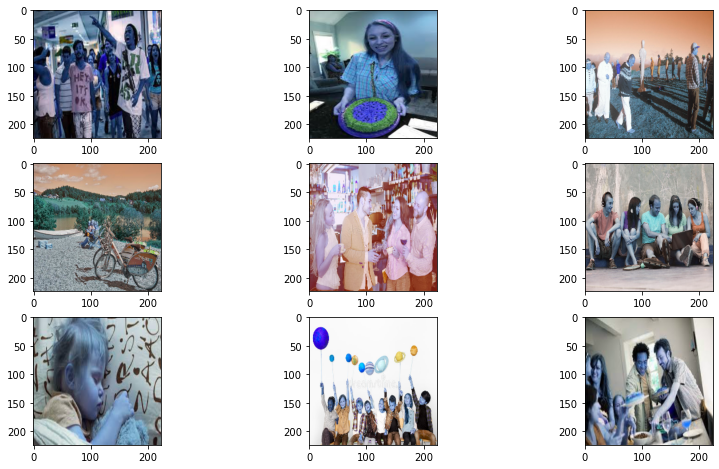

In [6]:
w=60
h=40

fig=plt.figure(figsize=(14, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = X[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Save Features and labels

In [7]:
np.save('features', X, allow_pickle=True, fix_imports=True)
np.save('labels', y, allow_pickle=True, fix_imports=True)

## Trainig


In [8]:
X = X/255.0      # Normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [9]:
ep = 15        # Epochs
bs = 32         # Batch size

## Augmenting Data

In [10]:
NAME = "friendship-day-classifier-{}".format(time.strftime("%d%h-%m-%S"))
tensorboard = TensorBoard(log_dir="""logs\{}""".format(NAME))

def cnn_model(X_train, X_test , y_train, y_test):
    
    base_model = applications.VGG16(include_top=False, input_shape=X_train.shape[1:], weights='imagenet',classes=CLASSES)

    # Freezing VGG16 layers
    for layer in base_model.layers:
        layer.trainable=False
    
    last_layer = 'block5_pool'
    model = Model(base_model.input, base_model.get_layer(last_layer).output)

    model.layers[-1].output.shape
    model = Sequential()

    model.add(base_model)      # Stack vgg16 

    model.add(Conv2D(128,(3,3),activation="relu", input_shape=model.layers[-1].output.shape, data_format='channels_first'))
    model.add(MaxPooling2D(2,2))
    
    
    model.add(Flatten())        # Flatten the output

    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(CLASSES, activation="softmax"))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=bs, epochs=ep, validation_data = (X_test, y_test), callbacks=[tensorboard])

    # Save model
    model.save('cnn.model')


cnn_model(X_train, X_test, y_train, y_test)

Train on 992 samples, validate on 249 samples
Epoch 1/15
992/992 [==============================] - 47s 48ms/sample - loss: 1.5119 - accuracy: 0.3982 - val_loss: 1.0720 - val_accuracy: 0.5100
Epoch 2/15
992/992 [==============================] - 34s 34ms/sample - loss: 1.0292 - accuracy: 0.4516 - val_loss: 0.9893 - val_accuracy: 0.5422
Epoch 3/15
992/992 [==============================] - 34s 34ms/sample - loss: 0.9579 - accuracy: 0.5181 - val_loss: 0.9740 - val_accuracy: 0.5261
Epoch 4/15
992/992 [==============================] - 34s 34ms/sample - loss: 0.8799 - accuracy: 0.5585 - val_loss: 0.9352 - val_accuracy: 0.5341
Epoch 5/15
992/992 [==============================] - 34s 34ms/sample - loss: 0.7986 - accuracy: 0.6250 - val_loss: 0.8621 - val_accuracy: 0.5783
Epoch 6/15
992/992 [==============================] - 34s 34ms/sample - loss: 0.7046 - accuracy: 0.6734 - val_loss: 0.8124 - val_accuracy: 0.6506
Epoch 7/15
992/992 [==============================] - 34s 34ms/sample - loss: 